# Rootzone model: build + rich features + walk-forward
Build master_data, engineer rich features, train RF on anchor intervals, and evaluate per-step.

In [56]:
# Repo paths (works even when notebook is in scripts/)
from pathlib import Path

def find_repo_root(start=None):
    start = Path.cwd() if start is None else Path(start)
    for p in [start, *start.parents]:
        if (p / 'data').exists():
            return p
    return start

ROOT = find_repo_root()
RAW = ROOT / 'data' / 'raw'
PROCESSED = ROOT / 'data' / 'processed'
PLOTS = ROOT / 'plots'
PLOTS.mkdir(exist_ok=True)


In [57]:
import pandas as pd
import numpy as np
from pathlib import Path
from collections import defaultdict
from datetime import datetime, timedelta, time
import csv
from typing import Any, Dict, List, Optional
from openpyxl import load_workbook
from sklearn.ensemble import RandomForestRegressor, HistGradientBoostingRegressor
from sklearn.multioutput import MultiOutputRegressor
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
from sklearn.model_selection import TimeSeriesSplit, ParameterGrid
from sklearn.inspection import permutation_importance
import matplotlib.pyplot as plt



In [58]:
from pathlib import Path
from typing import Optional

def find_repo_root(start: Optional[Path] = None) -> Path:
    p = (start or Path.cwd()).resolve()
    for parent in [p, *p.parents]:
        if (parent / 'data').exists():
            return parent
    return p

ROOT = find_repo_root()
RAW = ROOT / 'data' / 'raw'
PROCESSED = ROOT / 'data' / 'processed'
# OUTPUTS removed; use PROCESSED or PLOTS
print('ROOT:', ROOT)
print('RAW:', RAW)

def resolve_input(filename: str) -> Path:
    # prefer data/raw; fall back to repo root for backward compatibility
    p1 = RAW / filename
    p2 = PROCESSED / filename
    p3 = ROOT / filename
    if p1.exists():
        return p1
    if p2.exists():
        return p2
    if p3.exists():
        return p3
    raise FileNotFoundError(f'Cannot find {filename} in {RAW} or {ROOT}')


ROOT: C:\Users\edene\OneDrive\שולחן העבודה\Predictive_Modeling_Of_Rootzone_Variables_Using_Greenhouse_Data
RAW: C:\Users\edene\OneDrive\שולחן העבודה\Predictive_Modeling_Of_Rootzone_Variables_Using_Greenhouse_Data\data\raw


In [59]:
# Build master_data from raw files

def floor_to_10min(dt: datetime) -> datetime:
    minute = (dt.minute // 10) * 10
    return dt.replace(minute=minute, second=0, microsecond=0)

def parse_time_flex(text: str) -> time:
    text = text.strip()
    parts = text.split(":")
    if len(parts) >= 2:
        try:
            h = int(parts[0]); m = int(parts[1]); s = int(parts[2]) if len(parts) >= 3 and parts[2] else 0
            return time(hour=h, minute=m, second=s)
        except Exception:
            pass
    for fmt in ("%H:%M:%S", "%H:%M"):
        try:
            return datetime.strptime(text, fmt).time()
        except Exception:
            continue
    raise ValueError(f"Unrecognized time format: {text}")

def parse_ts_variant(text: str, day_first: bool) -> datetime:
    norm = text.replace("-", "/").replace(".", "/").strip()
    if " " not in norm:
        raise ValueError("No space between date and time")
    date_part, time_part = norm.split(" ", 1)
    t_val = parse_time_flex(time_part)
    parts = date_part.split("/")
    if len(parts) < 3:
        raise ValueError("Date part incomplete")
    a, b, y = parts[0], parts[1], parts[2]
    if len(y) == 2:
        y = "20" + y
    if day_first:
        day, month = int(a), int(b)
    else:
        month, day = int(a), int(b)
    return datetime(int(y), month, day, t_val.hour, t_val.minute, t_val.second)

def parse_micro_ts(value: Any, prev_ts: Optional[datetime]) -> datetime:
    if isinstance(value, datetime):
        ts = value
    else:
        text = str(value).strip()
        candidates = []
        for day_first in (True, False):
            try:
                candidates.append(parse_ts_variant(text, day_first))
            except Exception:
                continue
        if not candidates:
            raise ValueError(f"Unrecognized micro-climate timestamp: {value}")
        if prev_ts is not None:
            best = None; best_delta = None
            for dt in candidates:
                delta = dt - prev_ts
                if delta >= timedelta(minutes=-5) and (best_delta is None or delta < best_delta):
                    best = dt; best_delta = delta
            ts = best if best is not None else candidates[0]
        else:
            ts = candidates[0]
    return ts

def parse_time_robust(val: Any) -> time:
    if isinstance(val, datetime):
        return val.time()
    if isinstance(val, time):
        return val
    return parse_time_flex(str(val))

def parse_date_dayfirst(text: str) -> datetime.date:
    text = text.strip()
    norm = text.replace("-", "/").replace(".", "/")
    parts = norm.split("/")
    if len(parts) >= 3:
        d, m, y = parts[0], parts[1], parts[2]
        if len(y) == 2:
            y = "20" + y
        return datetime(int(y), int(m), int(d)).date()
    for fmt in ("%d/%m/%Y", "%d/%m/%y", "%Y-%m-%d"):
        try:
            return datetime.strptime(text, fmt).date()
        except Exception:
            continue
    raise ValueError(f"Unrecognized date format: {text}")

def read_micro(path: str) -> List[Dict[str, Any]]:
    wb = load_workbook(path, read_only=True, data_only=True)
    ws = wb["micro_climate_rh_t_et0"]
    rows = ws.iter_rows(values_only=True)
    next(rows)
    data = []
    prev_ts = None
    base_ts = None
    interval = timedelta(minutes=10)
    for row in rows:
        if not row or row[0] is None:
            continue
        raw_ts = parse_micro_ts(row[0], prev_ts)
        if base_ts is None:
            base_ts = raw_ts
            seq_ts = base_ts
        else:
            seq_ts = base_ts + interval * len(data)
        prev_ts = raw_ts
        data.append({
            "timestamp": seq_ts,
            "ET0": row[1],
            "internal_air_temp_c": row[2],
            "internal_rh_%": row[3],
            "internal_radiation": row[4],
        })
    return data

def read_irrigation(path: str):
    wb = load_workbook(path, read_only=True, data_only=True)
    ws = wb.active
    rows = ws.iter_rows(values_only=True)
    next(rows)
    events = []
    for row in rows:
        if not row or row[0] is None:
            continue
        date_val, time_val, irr_ml, fert_type = row[0], row[1], row[2], row[3]
        if isinstance(date_val, datetime):
            date_only = date_val.date()
        else:
            parsed = None
            for fmt in ("%Y-%m-%d", "%d/%m/%Y", "%m/%d/%Y", "%d.%m.%Y", "%m.%d.%Y"):
                try:
                    parsed = datetime.strptime(str(date_val), fmt).date(); break
                except Exception:
                    continue
            if parsed is None:
                parsed = parse_date_dayfirst(str(date_val))
            date_only = parsed
        t_val = parse_time_robust(time_val)
        dt = datetime.combine(date_only, t_val)
        bucket = floor_to_10min(dt)
        fert_code = 0
        if isinstance(fert_type, str):
            f = fert_type.strip().upper()
            if f == "A":
                fert_code = 1
            elif f == "B":
                fert_code = 2
        events.append({"bucket": bucket, "irr_ml": irr_ml or 0.0, "fert_code": fert_code})
    return events

def build_irrigation_series(events):
    fert_by_bucket = {}
    irr_by_bucket = defaultdict(float)
    for ev in events:
        irr_by_bucket[ev["bucket"]] += ev["irr_ml"]
        if ev["fert_code"]:
            fert_by_bucket[ev["bucket"]] = max(fert_by_bucket.get(ev["bucket"], 0), ev["fert_code"])
    return irr_by_bucket, fert_by_bucket

def parse_ph_ec_date(val: Any) -> Optional[datetime.date]:
    if isinstance(val, datetime):
        return val.date()
    if val is None:
        return None
    s = str(val).strip()
    if not s:
        return None
    for sep in (".", "/", "-"):
        if sep in s:
            parts = s.replace("-", sep).replace("/", sep).split(sep)
            if len(parts) >= 3:
                d_raw, m_raw, y_raw = parts[0], parts[1], parts[2]
                for day_first in (True, False):
                    day, month = (d_raw, m_raw) if day_first else (m_raw, d_raw)
                    year = y_raw
                    if len(year) == 2:
                        year = "20" + year
                    try:
                        return datetime(int(year), int(month), int(day)).date()
                    except Exception:
                        continue
    for fmt in ("%Y-%m-%d", "%Y/%m/%d", "%m.%d.%Y", "%d.%m.%Y", "%m-%d-%Y", "%d-%m-%Y"):
        try:
            return datetime.strptime(s, fmt).date()
        except Exception:
            continue
    return None

def read_ph_ec(path: str):
    wb = load_workbook(path, read_only=True, data_only=True)
    ws = wb.active
    rows = ws.iter_rows(values_only=True)
    next(rows)
    measurements = []
    for row in rows:
        if not row or row[1] is None:
            continue
        date_part = parse_ph_ec_date(row[1])
        time_part = row[4]
        if date_part is None or time_part is None:
            continue
        t_val = parse_time_robust(time_part)
        dt = datetime.combine(date_part, t_val)
        measurements.append({"timestamp": dt, "ph": row[2], "ec_ms": row[3]})
    return measurements

def map_ph_ec_to_micro(timestamps: List[datetime], measurements: List[Dict[str, Any]]):
    ph_list = [None] * len(timestamps)
    ec_list = [None] * len(timestamps)
    for m in measurements:
        best_idx = None; best_diff = None
        for idx, ts in enumerate(timestamps):
            diff = abs(ts - m["timestamp"])
            if diff <= timedelta(minutes=10) and (best_diff is None or diff < best_diff):
                best_idx = idx; best_diff = diff
        if best_idx is not None:
            ph_list[best_idx] = m["ph"]
            ec_list[best_idx] = m["ec_ms"]
    return ph_list, ec_list

def read_soil_temp(path: str):
    data = {}
    with open(path, newline="") as f:
        reader = csv.DictReader(f)
        for row in reader:
            ts = datetime.strptime(row["datetime"], "%Y-%m-%d %H:%M:%S")
            data[ts] = float(row["soil_temp_pred"]) if row["soil_temp_pred"] != "" else None
    return data

def read_canopy(path: str):
    wb = load_workbook(path, read_only=True, data_only=True)
    ws = wb.active
    rows = ws.iter_rows(values_only=True)
    header = [str(h).strip() if h is not None else "" for h in next(rows)]

    def find_contains(text: str):
        t = text.lower()
        for i, h in enumerate(header):
            if t in h.lower():
                return i
        return None

    date_idx = find_contains("date")
    canopy_idx = find_contains("canopy")
    dap_idx = find_contains("days after planting")
    if date_idx is None:
        date_idx = 4
    if canopy_idx is None:
        canopy_idx = 6

    canopy = {}
    dap = {}
    for row in rows:
        if len(row) <= max(date_idx, canopy_idx):
            continue
        date_val = row[date_idx]
        canopy_val = row[canopy_idx]
        dap_val = row[dap_idx] if dap_idx is not None and dap_idx < len(row) else None
        if date_val is None:
            continue
        if not isinstance(date_val, datetime):
            try:
                date_val = datetime.strptime(str(date_val), "%Y-%m-%d")
            except Exception:
                continue
        canopy[date_val.date()] = canopy_val
        if dap_val is not None:
            try:
                dap[date_val.date()] = float(dap_val)
            except Exception:
                pass
    return canopy, dap
def build_master():
    micro = read_micro(str(resolve_input("micro_climate_rh_t_et0.xlsx")))
    events = read_irrigation(str(resolve_input("Irrigation + ALL Elemental Fractions schedule for one plant (100N).xlsx")))
    irr_by_bucket, fert_by_bucket = build_irrigation_series(events)
    ph_ec = read_ph_ec(str(resolve_input("PH+EC Final.xlsx")))
    soil_temp = read_soil_temp(str(resolve_input("soil_temp_predictions_full_range.csv")))
    canopy, dap = read_canopy(str(resolve_input("Daily Canopy Cover Values.xlsx")))

    timestamps = [row["timestamp"] for row in micro]
    ph_list, ec_list = map_ph_ec_to_micro(timestamps, ph_ec)

    fert_flags = []
    soil_list = []
    canopy_list = []
    dap_list = []
    irr_current = []

    for i, ts in enumerate(timestamps):
        irr_now = irr_by_bucket.get(ts, 0.0)
        irr_current.append(irr_now)
        fert_flags.append(fert_by_bucket.get(ts, 0))
        soil_list.append(soil_temp.get(ts))
        canopy_list.append(canopy.get(ts.date()))
        dap_list.append(dap.get(ts.date()))

    df_out = pd.DataFrame({
        "timestamp": timestamps,
        "ET0": [r["ET0"] for r in micro],
        "internal_air_temp_c": [r["internal_air_temp_c"] for r in micro],
        "internal_rh_%": [r["internal_rh_%"] for r in micro],
        "internal_radiation": [r["internal_radiation"] for r in micro],
        "irrigation_ml_current": irr_current,
        "fertilization_flag": fert_flags,
        "ph": ph_list,
        "ec_ms": ec_list,
        "soil_temp_pred": soil_list,
        "canopy_cover": canopy_list,
        "days_after_planting": dap_list,
    })
    df_out = df_out.sort_values("timestamp").set_index("timestamp")
    out_path = PROCESSED / "master_data.csv"
    df_out.to_csv(out_path, index=True)
    print(f"Wrote {out_path} with {len(df_out)} rows")
    return df_out

print("Building master_data ...")
df = build_master()



Building master_data ...
Wrote C:\Users\edene\OneDrive\שולחן העבודה\Predictive_Modeling_Of_Rootzone_Variables_Using_Greenhouse_Data\data\processed\master_data.csv with 16682 rows


In [60]:
# Rich feature engineering on master (10-minute timeline)
pi = np.pi
hours = df.index.hour
days = df.index.dayofyear

feat_dict = {}
feat_dict['hour_sin'] = np.sin(2*pi*hours/24)
feat_dict['hour_cos'] = np.cos(2*pi*hours/24)
feat_dict['doy_sin'] = np.sin(2*pi*days/365)
feat_dict['doy_cos'] = np.cos(2*pi*days/365)
feat_dict['is_weekend'] = df.index.weekday.isin([5,6]).astype(int)

irr_amt = df['irrigation_ml_current'].fillna(0)
irr_flag = (irr_amt > 0).astype(int)
fert_flag = (df['fertilization_flag'].fillna(0) > 0).astype(int)
fert_a = (df['fertilization_flag'] == 1).astype(int)
fert_b = (df['fertilization_flag'] == 2).astype(int)
feat_dict['irrigation_flag'] = irr_flag
feat_dict['fertigation_flag'] = fert_flag
feat_dict['fert_a_flag'] = fert_a
feat_dict['fert_b_flag'] = fert_b

idx_series = pd.Series(df.index, index=df.index)
last_irr_time = pd.Series(df.index.where(irr_flag==1), index=df.index).ffill()
last_fert_time = pd.Series(df.index.where(fert_flag==1), index=df.index).ffill()
feat_dict['time_since_irrigation_minutes'] = (idx_series - last_irr_time).dt.total_seconds() / 60
feat_dict['time_since_fertigation_minutes'] = (idx_series - last_fert_time).dt.total_seconds() / 60

windows = {6:'1h', 18:'3h', 36:'6h', 144:'24h'}
for win,name in windows.items():
    feat_dict[f'irr_sum_{name}'] = irr_amt.rolling(win, min_periods=1).sum()
    feat_dict[f'irr_flag_count_{name}'] = irr_flag.rolling(win, min_periods=1).sum()
    feat_dict[f'irr_flag_density_{name}'] = feat_dict[f'irr_flag_count_{name}'] / win
    if win in (36,144):
        feat_dict[f'fert_count_{name}'] = fert_flag.rolling(win, min_periods=1).sum()
        feat_dict[f'fert_a_count_{name}'] = fert_a.rolling(win, min_periods=1).sum()
        feat_dict[f'fert_b_count_{name}'] = fert_b.rolling(win, min_periods=1).sum()
        feat_dict[f'fert_density_{name}'] = feat_dict[f'fert_count_{name}'] / win

climate_cols = ['internal_air_temp_c','internal_rh_%','internal_radiation','ET0']
for col in climate_cols:
    for win,name in windows.items():
        feat_dict[f'{col}_roll_mean_{name}'] = df[col].rolling(win, min_periods=1).mean()
        feat_dict[f'{col}_roll_std_{name}'] = df[col].rolling(win, min_periods=1).std()
        feat_dict[f'{col}_roll_min_{name}'] = df[col].rolling(win, min_periods=1).min()
        feat_dict[f'{col}_roll_max_{name}'] = df[col].rolling(win, min_periods=1).max()
    feat_dict[f'{col}_diff_10m'] = df[col].diff()
    feat_dict[f'{col}_diff_1h'] = df[col] - df[col].shift(6)
    feat_dict[f'{col}_slope_1h'] = (df[col] - df[col].shift(6)) / 6
    feat_dict[f'{col}_slope_3h'] = (df[col] - df[col].shift(18)) / 18

feat_dict['vpd_proxy'] = (1 - df['internal_rh_%']/100.0) * df['internal_air_temp_c']

if 'soil_temp_pred' in df.columns:
    for win,name in {36:'6h', 144:'24h'}.items():
        feat_dict[f'soil_temp_mean_{name}'] = df['soil_temp_pred'].rolling(win, min_periods=1).mean()
        feat_dict[f'soil_temp_std_{name}'] = df['soil_temp_pred'].rolling(win, min_periods=1).std()
        feat_dict[f'soil_temp_slope_{name}'] = (df['soil_temp_pred'] - df['soil_temp_pred'].shift(win)) / win


feat_dict['rad_x_temp'] = df['internal_radiation'] * df['internal_air_temp_c']
feat_dict['et0_x_temp'] = df['ET0'] * df['internal_air_temp_c']
feat_dict['rh_x_temp'] = df['internal_rh_%'] * df['internal_air_temp_c']
feat_dict['irr6h_x_radiation'] = feat_dict['irr_sum_6h'] * df['internal_radiation']

feat_df = pd.DataFrame(feat_dict, index=df.index)
# Save full master timeline with engineered features (no filtering on pH/EC)
master_with_features = df.join(pd.DataFrame(feat_dict, index=df.index))
master_features_path = PROCESSED / 'master_data_with_features.csv'
master_with_features.to_csv(master_features_path)
print('Saved', master_features_path, 'rows:', len(master_with_features), 'cols:', master_with_features.shape[1])
mask_all = feat_df.notna().all(axis=1)
feat_df = feat_df.loc[mask_all]
df_feat = df.loc[mask_all]
print('feature rows', len(feat_df))


Saved C:\Users\edene\OneDrive\שולחן העבודה\Predictive_Modeling_Of_Rootzone_Variables_Using_Greenhouse_Data\data\processed\master_data_with_features.csv rows: 16682 cols: 133
feature rows 16512


In [61]:
# Build ds with anchor intervals + interval-aggregated features (t0 -> t1)
#
# Real-life intent:
# - At time t0 (current pH/EC), you also have a climate forecast over (t0, t1]
#   and a planned irrigation/fert schedule over (t0, t1].
# - So we summarize the *interval inputs* between samples and learn to predict the next sample.

anchors = df[df['ph'].notna() & df['ec_ms'].notna()].copy()
anchors['t1'] = anchors.index.to_series().shift(-1)
anchors['ph1'] = anchors['ph'].shift(-1)
anchors['ec1'] = anchors['ec_ms'].shift(-1)
anchors['gap_hours'] = (anchors['t1'] - anchors.index.to_series()).dt.total_seconds() / 3600
anchors['dph'] = anchors['ph1'] - anchors['ph']
anchors['dec'] = anchors['ec1'] - anchors['ec_ms']
anchors = anchors.dropna(subset=['t1','ph1','ec1','dph','dec'])

def build_interval_features(master: pd.DataFrame, intervals: pd.DataFrame) -> pd.DataFrame:
    rows = []
    start_time = master.index.min()
    for t0, row in intervals.iterrows():
        t1 = row['t1']
        seg = master.loc[t0:t1]
        feats: Dict[str, Any] = {}

        # Current observed rootzone state
        feats['ph0'] = float(row['ph'])
        feats['ec0'] = float(row['ec_ms'])
        feats['gap_hours'] = float(row['gap_hours'])
        feats['interval_steps_10m'] = int(len(seg))
        if 'days_after_planting' in seg.columns:
            dap = pd.to_numeric(seg['days_after_planting'], errors='coerce')
            if dap.notna().any():
                feats['days_since_start'] = float(dap.dropna().iloc[0])
            else:
                feats['days_since_start'] = (t0 - start_time).total_seconds() / 86400
        else:
            feats['days_since_start'] = (t0 - start_time).total_seconds() / 86400

        # Planned/observed actions between samples (aggregate over the interval)
        irr_sum = 0.0
        if 'irrigation_ml_current' in seg.columns:
            irr = pd.to_numeric(seg['irrigation_ml_current'], errors='coerce').fillna(0.0)
            irr_sum = float(irr.sum())
            feats['irr_ml_sum_t0_t1'] = irr_sum
            feats['irr_event_count_t0_t1'] = int((irr > 0).sum())
            last_irr_idx = irr[irr > 0].index.max() if (irr > 0).any() else None
            if last_irr_idx is not None:
                feats['last_event_age'] = (t1 - last_irr_idx).total_seconds() / 60
            else:
                feats['last_event_age'] = feats['gap_hours'] * 60 if feats['gap_hours'] > 0 else np.nan
        else:
            feats['irr_ml_sum_t0_t1'] = 0.0
            feats['irr_event_count_t0_t1'] = 0
            feats['last_event_age'] = feats['gap_hours'] * 60 if feats['gap_hours'] > 0 else np.nan

        fert_event_count = 0
        fert_a_count = 0
        fert_b_count = 0
        if 'fertilization_flag' in seg.columns:
            fert = pd.to_numeric(seg['fertilization_flag'], errors='coerce').fillna(0)
            fert_event_count = int((fert > 0).sum())
            fert_a_count = int((fert == 1).sum())
            fert_b_count = int((fert == 2).sum())
        feats['fert_event_count_t0_t1'] = fert_event_count
        feats['fert_a_count_t0_t1'] = fert_a_count
        feats['fert_b_count_t0_t1'] = fert_b_count
        if fert_a_count > 0:
            feats['fert_type_binary'] = 1
        elif fert_b_count > 0:
            feats['fert_type_binary'] = 2
        else:
            feats['fert_type_binary'] = 0

        # Climate aggregates over the interval (use your predicted climate columns here if available)
        climate_cols = ['internal_air_temp_c', 'internal_rh_%', 'internal_radiation', 'ET0']
        for col in climate_cols:
            if col not in seg.columns:
                continue
            s = pd.to_numeric(seg[col], errors='coerce')
            feats[f'{col}_mean_t0_t1'] = float(s.mean())
            feats[f'{col}_std_t0_t1'] = float(s.std(ddof=0))
            feats[f'{col}_min_t0_t1'] = float(s.min())
            feats[f'{col}_max_t0_t1'] = float(s.max())
            feats[f'{col}_sum_t0_t1'] = float(s.sum())
            if len(s) >= 1:
                feats[f'{col}_delta_t0_t1'] = float(s.iloc[-1] - s.iloc[0])

        # VPD proxy (example derived interval aggregate)
        if 'internal_rh_%' in seg.columns and 'internal_air_temp_c' in seg.columns:
            rh = pd.to_numeric(seg['internal_rh_%'], errors='coerce')
            t = pd.to_numeric(seg['internal_air_temp_c'], errors='coerce')
            vpd_proxy = (1 - rh / 100.0) * t
            feats['vpd_proxy_mean_t0_t1'] = float(vpd_proxy.mean())
            feats['vpd_proxy_max_t0_t1'] = float(vpd_proxy.max())

        # Optional context variables
        if 'soil_temp_pred' in seg.columns:
            st = pd.to_numeric(seg['soil_temp_pred'], errors='coerce')
            feats['soil_temp_mean_t0_t1'] = float(st.mean())
            feats['soil_temp_std_t0_t1'] = float(st.std(ddof=0))
            feats['soil_temp_min_t0_t1'] = float(st.min())
            feats['soil_temp_max_t0_t1'] = float(st.max())
        if 'canopy_cover' in seg.columns:
            cc = pd.to_numeric(seg['canopy_cover'], errors='coerce')
            feats['canopy_mean_t0_t1'] = float(cc.mean())
            feats['canopy_t0'] = float(cc.iloc[0]) if len(cc) else np.nan
            feats['canopy_t1'] = float(cc.iloc[-1]) if len(cc) else np.nan

        # Derived features for the final model
        feats['avg_vpd'] = feats.get('vpd_proxy_mean_t0_t1', np.nan)
        if 'internal_radiation_sum_t0_t1' in feats and feats['gap_hours'] > 0:
            feats['rad_sum_per_hour'] = feats['internal_radiation_sum_t0_t1'] / feats['gap_hours']
        else:
            feats['rad_sum_per_hour'] = np.nan
        feats['soil_temp_mean'] = feats.get('soil_temp_mean_t0_t1', np.nan)
        if 'internal_air_temp_c_max_t0_t1' in feats and 'internal_air_temp_c_min_t0_t1' in feats:
            feats['temp_flux'] = feats['internal_air_temp_c_max_t0_t1'] - feats['internal_air_temp_c_min_t0_t1']
        else:
            feats['temp_flux'] = np.nan
        feats['total_irrig_vol'] = irr_sum
        feats['fert_event_count'] = fert_event_count
        feats['irrig_to_gap_ratio'] = irr_sum / feats['gap_hours'] if feats['gap_hours'] > 0 else np.nan

        rows.append(feats)

    return pd.DataFrame(rows, index=intervals.index)

interval_feats = build_interval_features(df, anchors)
ds = pd.concat([anchors[['t1', 'dph', 'dec']], interval_feats], axis=1)

# Drop any rows with NaNs in features (RF cannot handle NaNs)
feature_cols_tmp = [c for c in ds.columns if c not in ['t1', 'dph', 'dec']]
ds = ds.dropna(subset=feature_cols_tmp)
print('Built ds with intervals:', len(ds), '| features:', len(feature_cols_tmp))




Built ds with intervals: 108 | features: 52


## Targets
This notebook predicts only pH/EC deltas (`dph`, `dec`). `soil_temp_pred` is used only as an input feature (context), not as a target.

In [62]:
# Walk-forward on ds using RF (rate targets) + constrained feature set
ds['irrig_rate'] = ds['total_irrig_vol'] / ds['gap_hours']

feature_cols = [
    'ph0',
    'avg_vpd',
    'rad_sum_per_hour',
    'soil_temp_mean',
    'temp_flux',
    'gap_hours',
    'ec0',
    'last_event_age',
    'days_since_start',
    'irrig_rate',
    'fert_type_binary',
    'fert_event_count',
 ]


missing_feats = [c for c in feature_cols if c not in ds.columns]
if missing_feats:
    raise KeyError(f"Missing features: {missing_feats}")

X_all = ds[feature_cols]
y_dph_rate = ds['dph'] / ds['gap_hours']
y_dec_rate = ds['dec'] / ds['gap_hours']

rf_params = dict(
    n_estimators=500,
    max_depth=4,
    min_samples_leaf=6,
    min_samples_split=2,
    max_features='sqrt',
    oob_score=True,
    random_state=42,
    n_jobs=-1,
 )

print(f"Selected {len(feature_cols)} features for both dph and dec.")

initial_train = min(30, max(5, len(ds)//5))
if len(ds) <= initial_train + 1:
    raise RuntimeError(f"Not enough intervals: n={len(ds)} for initial_train={initial_train}")

pred_rows = []
for i in range(initial_train, len(ds)):
    X_train = X_all.iloc[:i]
    X_test = X_all.iloc[i:i+1]

    dph_model = RandomForestRegressor(**rf_params)
    dec_model = RandomForestRegressor(**rf_params)
    dph_model.fit(X_train, y_dph_rate.iloc[:i])
    dec_model.fit(X_train, y_dec_rate.iloc[:i])

    gap_hours = float(ds.iloc[i]['gap_hours'])
    dph_rate_pred = float(dph_model.predict(X_test)[0])
    dec_rate_pred = float(dec_model.predict(X_test)[0])
    dph_pred = dph_rate_pred * gap_hours
    dec_pred = dec_rate_pred * gap_hours
    ph0 = float(ds.iloc[i]['ph0']); ec0 = float(ds.iloc[i]['ec0'])
    dph_true = float(ds.iloc[i]['dph']); dec_true = float(ds.iloc[i]['dec'])
    ph1_true = ph0 + dph_true; ec1_true = ec0 + dec_true
    ph1_pred = ph0 + dph_pred; ec1_pred = ec0 + dec_pred

    pred_rows.append({
        't0': ds.index[i], 't1': ds.iloc[i]['t1'], 'gap_hours': gap_hours,
        'ph0': ph0, 'ec0': ec0,
        'ph1_true': ph1_true, 'ec1_true': ec1_true,
        'ph1_pred': ph1_pred, 'ec1_pred': ec1_pred,
        'dph_true': dph_true, 'dec_true': dec_true,
        'dph_pred': dph_pred, 'dec_pred': dec_pred,
        'dph_rate_pred': dph_rate_pred, 'dec_rate_pred': dec_rate_pred,
        'train_intervals': i
    })

pred_df = pd.DataFrame(pred_rows).set_index('t0').sort_index()
print('Tested intervals:', len(pred_df), 'of', len(ds), '| first test idx:', initial_train)

ph1_true = pred_df['ph1_true'].values; ph1_pred = pred_df['ph1_pred'].values
ec1_true = pred_df['ec1_true'].values; ec1_pred = pred_df['ec1_pred'].values

def rmse(a,b):
    return float(np.sqrt(mean_squared_error(a,b)))
print("=== Overall next-observation performance ===")
print("PH MAE:", float(mean_absolute_error(ph1_true, ph1_pred)), "RMSE:", rmse(ph1_true, ph1_pred), "R2:", float(r2_score(ph1_true, ph1_pred)))
print("EC MAE:", float(mean_absolute_error(ec1_true, ec1_pred)), "RMSE:", rmse(ec1_true, ec1_pred), "R2:", float(r2_score(ec1_true, ec1_pred)))

# Metrics by fixed gap-hours bins
gap_bins = [-np.inf, 4, 8, 12, np.inf]
gap_labels = ['0-4h', '4-8h', '8-12h', '12+h']
def metrics_block(y_true, y_pred):
    return {
        'mae': float(mean_absolute_error(y_true, y_pred)),
        'rmse': rmse(y_true, y_pred),
        'r2': float(r2_score(y_true, y_pred))
    }

pred_df['gap_bin'] = pd.cut(pred_df['gap_hours'], bins=gap_bins, labels=gap_labels, include_lowest=True)
bin_rows = []
for gap_bin, grp in pred_df.groupby('gap_bin'):
    if len(grp) == 0:
        continue
    phm = metrics_block(grp['ph1_true'], grp['ph1_pred'])
    ecm = metrics_block(grp['ec1_true'], grp['ec1_pred'])
    bin_rows.append({
        'gap_bin': gap_bin,
        'count': int(len(grp)),
        'ph_mae': phm['mae'], 'ph_rmse': phm['rmse'], 'ph_r2': phm['r2'],
        'ec_mae': ecm['mae'], 'ec_rmse': ecm['rmse'], 'ec_r2': ecm['r2']
    })

bin_df = pd.DataFrame(bin_rows).sort_values('gap_bin')
print("=== Metrics by gap-hours bins ===")
display(bin_df)

pred_df['ph_abs_error'] = np.abs(pred_df['ph1_pred'] - pred_df['ph1_true'])
pred_df['ec_abs_error'] = np.abs(pred_df['ec1_pred'] - pred_df['ec1_true'])
pred_df['ph_signed_error'] = pred_df['ph1_pred'] - pred_df['ph1_true']
pred_df['ec_signed_error'] = pred_df['ec1_pred'] - pred_df['ec1_true']
print('\nPer-interval true vs predicted (all tested intervals):')
tbl = pred_df[['t1','gap_hours','ph1_true','ph1_pred','ec1_true','ec1_pred','ph_abs_error','ec_abs_error']].copy()
tbl = tbl.reset_index().rename(columns={'t0':'t0'})
tbl = tbl.rename(columns={tbl.columns[0]:'t0'})
tbl['gap_hours'] = tbl['gap_hours'].astype(float).round(3)
tbl['ph1_true'] = tbl['ph1_true'].astype(float).round(6)
tbl['ph1_pred'] = tbl['ph1_pred'].astype(float).round(6)
tbl['ec1_true'] = tbl['ec1_true'].astype(float).round(6)
tbl['ec1_pred'] = tbl['ec1_pred'].astype(float).round(6)
tbl['ph_abs_error'] = tbl['ph_abs_error'].astype(float).round(6)
tbl['ec_abs_error'] = tbl['ec_abs_error'].astype(float).round(6)
pd.set_option('display.max_rows', None)
pd.set_option('display.max_columns', None)
display(tbl)







Selected 12 features for both dph and dec.


c:\Users\edene\anaconda3\envs\tf-cpu\Lib\site-packages\sklearn\utils\parallel.py:144: UserWarning: `sklearn.utils.parallel.delayed` should be used with `sklearn.utils.parallel.Parallel` to make it possible to propagate the scikit-learn configuration of the current thread to the joblib workers.
  warnings.warn(
c:\Users\edene\anaconda3\envs\tf-cpu\Lib\site-packages\sklearn\utils\parallel.py:144: UserWarning: `sklearn.utils.parallel.delayed` should be used with `sklearn.utils.parallel.Parallel` to make it possible to propagate the scikit-learn configuration of the current thread to the joblib workers.
  warnings.warn(
c:\Users\edene\anaconda3\envs\tf-cpu\Lib\site-packages\sklearn\utils\parallel.py:144: UserWarning: `sklearn.utils.parallel.delayed` should be used with `sklearn.utils.parallel.Parallel` to make it possible to propagate the scikit-learn configuration of the current thread to the joblib workers.
  warnings.warn(
c:\Users\edene\anaconda3\envs\tf-cpu\Lib\site-packages\sklearn\u

Tested intervals: 87 of 108 | first test idx: 21
=== Overall next-observation performance ===
PH MAE: 0.7952545207875141 RMSE: 1.2152341643982754 R2: 0.21782657970937747
EC MAE: 0.33758285229378676 RMSE: 0.6204498984203834 R2: 0.7541017532414146
=== Metrics by gap-hours bins ===


C:\Users\edene\AppData\Local\Temp\ipykernel_11148\1955809932.py:100: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  for gap_bin, grp in pred_df.groupby('gap_bin'):


,gap_bin,count,ph_mae,ph_rmse,ph_r2,ec_mae,ec_rmse,ec_r2
0,0-4h,44,0.561278,0.799996,0.767217,0.249937,0.621782,0.811795
2,12+h,30,1.007601,1.610659,-3.827775,0.351782,0.457135,0.720331
1,4-8h,13,1.097145,1.315431,-1.514372,0.601465,0.886271,0.544173



Per-interval true vs predicted (all tested intervals):


,t0,t1,gap_hours,ph1_true,ph1_pred,ec1_true,ec1_pred,ph_abs_error,ec_abs_error
0,2025-08-06 10:00:00,2025-08-06 16:30:00,6.500,8.83,7.956431,2.25000,0.847839,0.873569,1.402161
1,2025-08-06 16:30:00,2025-08-07 10:00:00,17.500,8.05,8.839989,2.36000,1.952758,0.789989,0.407242
2,2025-08-07 10:00:00,2025-08-07 13:00:00,3.000,8.11,8.188273,2.30000,2.376919,0.078273,0.076919
3,2025-08-07 13:00:00,2025-08-10 08:20:00,67.333,7.48,8.745786,2.18000,1.451716,1.265786,0.728284
4,2025-08-10 08:20:00,2025-08-10 15:20:00,7.000,8.70,7.820150,4.18000,1.956524,0.879850,2.223476
5,2025-08-10 15:20:00,2025-08-11 08:10:00,16.833,7.44,9.003577,3.29000,4.145677,1.563577,0.855677
6,2025-08-11 08:10:00,2025-08-12 08:30:00,24.333,7.81,7.682089,1.47300,2.793547,0.127911,1.320547
7,2025-08-12 08:30:00,2025-08-13 11:20:00,26.833,7.41,8.209784,2.13000,1.715532,0.799784,0.414468
8,2025-08-13 11:20:00,2025-08-14 12:30:00,25.167,8.12,7.809326,2.39000,1.925438,0.310674,0.464562
9,2025-08-14 12:30:00,2025-08-14 16:20:00,3.833,8.63,8.323111,2.52000,2.415565,0.306889,0.104435


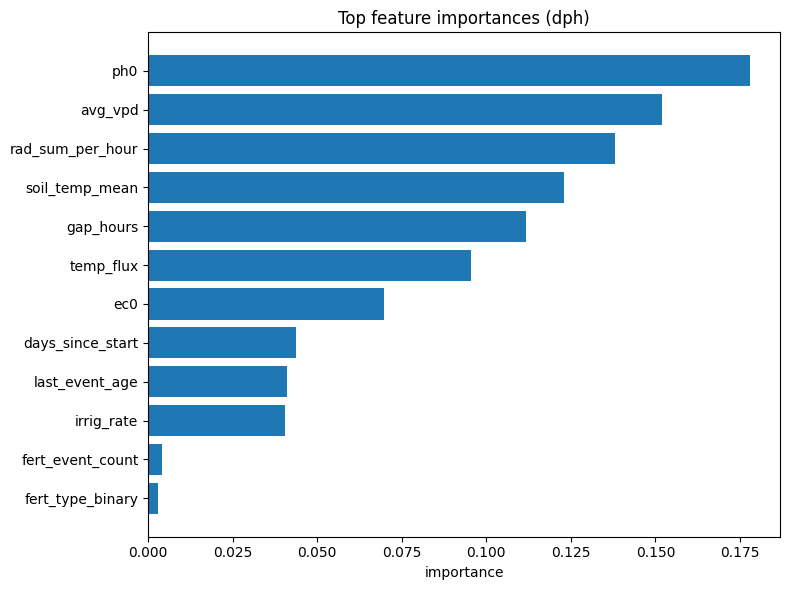

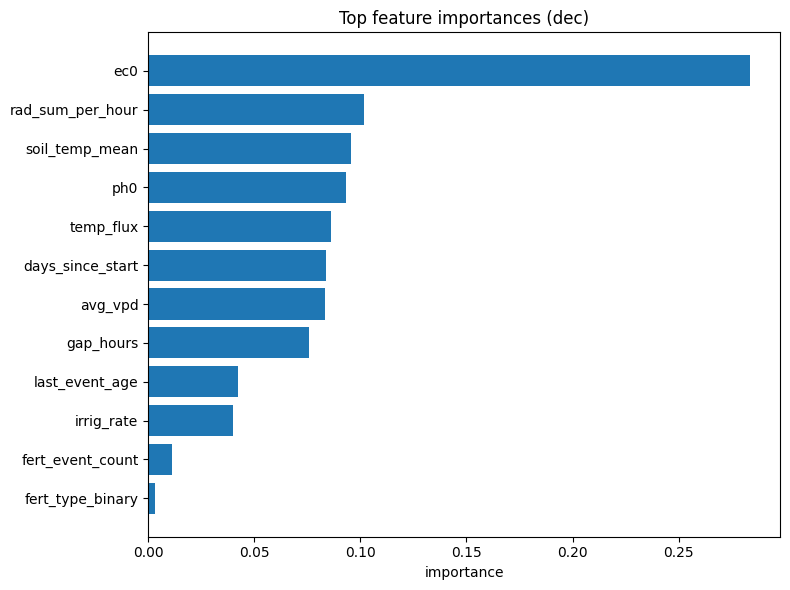

In [63]:
# Feature importance (display only) for the constrained feature set
dph_rf = RandomForestRegressor(**rf_params)
dec_rf = RandomForestRegressor(**rf_params)
dph_rf.fit(X_all, y_dph)
dec_rf.fit(X_all, y_dec)

for tgt_name, est in [
    ('dph', dph_rf),
    ('dec', dec_rf),
 ]:
    imp = pd.Series(est.feature_importances_, index=feature_cols).sort_values(ascending=False)
    top = imp.head(min(25, len(imp)))
    plt.figure(figsize=(8,6))
    plt.barh(top.index[::-1], top.values[::-1])
    plt.title(f'Top feature importances ({tgt_name})')
    plt.xlabel('importance')
    plt.tight_layout()
    plt.show()



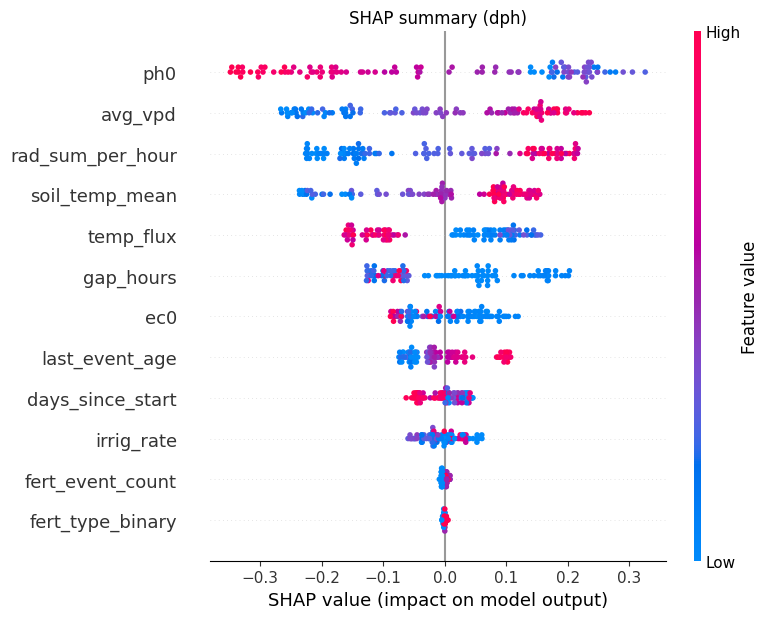

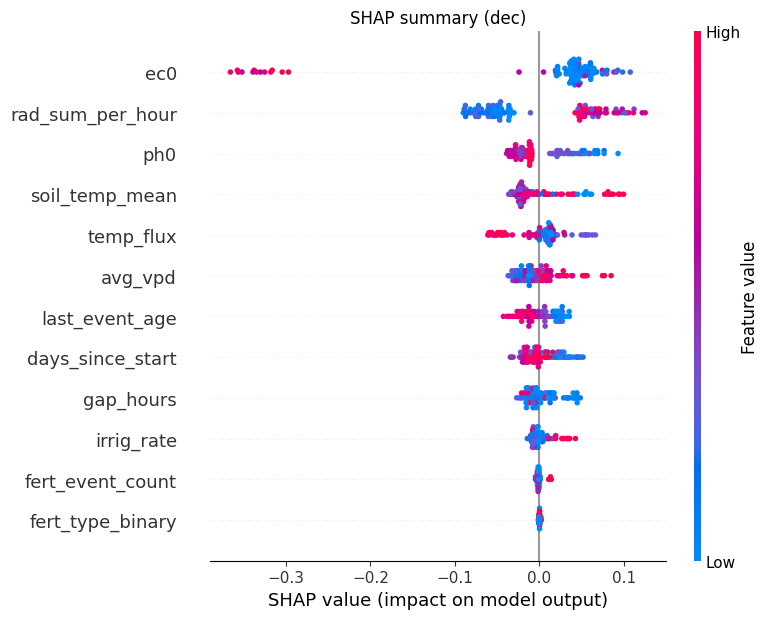

In [64]:
# SHAP summary plots (if shap is installed)
try:
    import shap
except ImportError as e:
    raise ImportError('shap is not installed in this environment. Install with: pip install shap') from e

# Train final models once (same as used in feature importances)
dph_final = RandomForestRegressor(**rf_params)
dec_final = RandomForestRegressor(**rf_params)
dph_final.fit(X_all, y_dph)
dec_final.fit(X_all, y_dec)

# Use a sample to keep runtime reasonable
X_sample = X_all.sample(n=min(300, len(X_all)), random_state=42)

for tgt_name, est in [
    ('dph', dph_final),
    ('dec', dec_final),
 ]:
    explainer = shap.TreeExplainer(est)
    shap_values = explainer.shap_values(X_sample)
    plt.figure()
    shap.summary_plot(shap_values, X_sample, show=False)
    plt.title(f'SHAP summary ({tgt_name})')
    plt.tight_layout()
    plt.show()



In [65]:
PROCESSED.mkdir(parents=True, exist_ok=True)
pred_df.to_csv(PROCESSED / 'rf_rootzone_model.csv')
print('Saved', PROCESSED / 'rf_rootzone_model.csv')
pred_df[['ph_abs_error','ec_abs_error','ph_signed_error','ec_signed_error']].to_csv(PROCESSED / 'per_interval_errors.csv')
print('Saved', PROCESSED / 'per_interval_errors.csv')


Saved C:\Users\edene\OneDrive\שולחן העבודה\Predictive_Modeling_Of_Rootzone_Variables_Using_Greenhouse_Data\data\processed\rf_rootzone_model.csv
Saved C:\Users\edene\OneDrive\שולחן העבודה\Predictive_Modeling_Of_Rootzone_Variables_Using_Greenhouse_Data\data\processed\per_interval_errors.csv
